# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env restrict the behaviour of RL learner to pair trading only

## Import the Custom Trading Env

In [1]:
import os
import csv
import pickle
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt
from tqdm import trange
from stable_baselines3 import PPO, A2C, DQN

from params import *
from utils.read2df import read2df, unify_dfs
from utils.clearlogs import clear_logs
from utils.rlmetrics import get_return, get_metrics
from envs.env_rl_restrict_thres import RL_Restrict_TradeEnv

folder_path = f"result/rl-restrict-thres"
os.makedirs(folder_path, exist_ok=True)

## Prepare Trading Data
Load data from `preliminaries.ipynb`

In [2]:
with open('result/cointncorr.pickle', 'rb') as pk:
    cointncorr = pickle.load(pk)

with open('result/gridsearch/best_res.pickle', 'rb') as pk:
    best_profit, best_params = pickle.load(pk)

dfs = read2df(symbols=cointncorr[0], freqs={cointncorr[1]: freqs[cointncorr[1]]}, marketType='spot')
tics, df = unify_dfs(dfs, symbols=cointncorr[0], period=best_params['period'])

In [3]:
df.tail(20)

,time,close0,itvl,datetime,close1,spread,zscore
128320,1703817659999,0.000474,1m,2023-12-29 02:40:59.999,0.000514,-0.000041,0.004392
128321,1703817719999,0.000474,1m,2023-12-29 02:41:59.999,0.000515,-0.000041,-0.056085
128322,1703817779999,0.000474,1m,2023-12-29 02:42:59.999,0.000517,-0.000044,-0.372399
128323,1703817839999,0.000474,1m,2023-12-29 02:43:59.999,0.000517,-0.000044,-0.374169
128324,1703817899999,0.000474,1m,2023-12-29 02:44:59.999,0.000517,-0.000044,-0.376171
128325,1703817959999,0.000473,1m,2023-12-29 02:45:59.999,0.000517,-0.000044,-0.441476
128326,1703818019999,0.000473,1m,2023-12-29 02:46:59.999,0.000517,-0.000044,-0.425762
128327,1703818079999,0.000473,1m,2023-12-29 02:47:59.999,0.000517,-0.000044,-0.482393
128328,1703818139999,0.000473,1m,2023-12-29 02:48:59.999,0.000517,-0.000044,-0.511045
128329,1703818199999,0.000473,1m,2023-12-29 02:49:59.999,0.000517,-0.000044,-0.513895


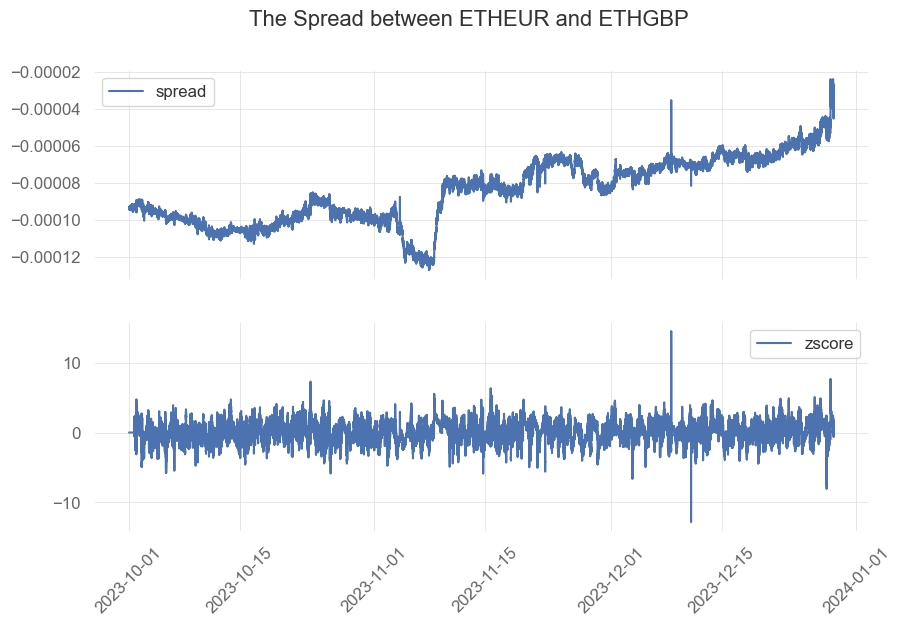

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(df['datetime'], df['spread'], label='spread')
ax2.plot(df['datetime'], df['zscore'], label='zscore')

ax1.legend()
ax2.legend()
plt.suptitle(f'The Spread between {cointncorr[0][0]} and {cointncorr[0][1]}')

plt.xticks(rotation=45)
plt.show()

In [5]:
train = df[(df['datetime'] >= datetime.strptime(start_date, date_format)) & (df['datetime'] < datetime.strptime(trade_date, date_format))]
test = df[(df['datetime'] >= datetime.strptime(trade_date, date_format)) & (df['datetime'] < datetime.strptime(end_date, date_format))]

max_train_len = int((len(train)-best_params['period']) * 0.95)
print(f"The length of our training data: {len(train)}")

The length of our training data: 44640


## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [6]:
from stable_baselines3.common.env_checker import check_env

env = RL_Restrict_TradeEnv(train)
obs, _ = env.reset()
check_env(env)

Tensorboard

## Train the Model with Trading Env

In [7]:
log_path = f"logs/restrict_thres/"
clear_logs(log_path)

# Read more about tensorboard
# https://github.com/tensorflow/tensorboard/blob/master/README.md
# https://www.tensorflow.org/tensorboard/get_started

Deleted: logs/restrict_thres/A2C_1
Deleted: logs/restrict_thres/DQN_1
Deleted: logs/restrict_thres/PPO_1


In [8]:
'''PPO'''

model_ppo = PPO("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_ppo.learn(total_timesteps=max_train_len, progress_bar=True)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

Output()

In [9]:
'''A2C'''

model_a2c = A2C("MultiInputPolicy", env, verbose=0, gamma=1, tensorboard_log=log_path)
model_a2c.learn(total_timesteps=max_train_len, progress_bar=True)
model_a2c.save(f"{folder_path}/a2c_pairtrading")

Output()

In [10]:
'''DQN'''

model_dqn = DQN("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_dqn.learn(total_timesteps=max_train_len, progress_bar=True)
model_dqn.save(f"{folder_path}/dqn_pairtrading")

Output()

## Create the Custom Test Env

In [11]:
test_env_ppo = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_ppo.csv", verbose=1)
test_env_a2c = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_a2c.csv", verbose=1)
test_env_dqn = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_dqn.csv", verbose=1)
test_env_expt = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_expt.csv", verbose=1)

In [12]:
max_test_len = int(len(test) * 0.95)
print(f"The length of our test data: {max_test_len}")

The length of our test data: 41040


## Test Env with Trained Model

In [13]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
except OSError:
    pass

obs, _ = test_env_ppo.reset()

for i in trange(max_test_len):
    action, _states = model_ppo.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_ppo.step(action)
    if i%int(max_test_len/10)==0:
        test_env_ppo.render()

test_env_ppo.close()

  0%|          | 11/41040 [00:00<06:16, 108.88it/s]

signal: {'position': 1, 'zone': 4, 'zscore': array([-2.00894742])}, action: 1, reward:0, networth: 1.0


 10%|█         | 4111/41040 [00:47<08:14, 74.70it/s] 

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.1520439])}, action: 1, reward:10, networth: 1.0045


 20%|██        | 8221/41040 [01:30<05:34, 97.97it/s] 

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.08627466])}, action: 1, reward:10, networth: 1.0054


 30%|███       | 12331/41040 [02:12<04:53, 97.66it/s] 

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.04332489])}, action: 1, reward:10, networth: 1.0057


 40%|████      | 16429/41040 [02:52<04:21, 94.02it/s] 

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.53540716])}, action: 1, reward:10, networth: 1.0076


 50%|█████     | 20539/41040 [03:34<03:30, 97.37it/s] 

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.02932751])}, action: 1, reward:10, networth: 1.0117


 60%|██████    | 24641/41040 [04:12<02:19, 117.87it/s]

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.38472686])}, action: 1, reward:10, networth: 1.0183


 70%|███████   | 28748/41040 [04:49<02:01, 101.13it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.68014561])}, action: 1, reward:10, networth: 1.0227


 80%|████████  | 32851/41040 [05:30<01:18, 104.99it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60771416])}, action: 1, reward:10, networth: 1.0264


 90%|█████████ | 36947/41040 [06:10<00:39, 103.00it/s]

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.30703784])}, action: 1, reward:0, networth: 1.0258


100%|██████████| 41040/41040 [06:47<00:00, 100.60it/s]

Finished
networth: 1.0281806862041427


In [14]:
try:
    os.remove(f"{folder_path}/networth_a2c.csv")
except OSError:
    pass

obs, _ = test_env_a2c.reset()

for i in trange(max_test_len):
    action, _states = model_a2c.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_a2c.step(action)
    if i%int(max_test_len/10)==0:
        test_env_a2c.render()

test_env_a2c.close()

  0%|          | 12/41040 [00:00<05:48, 117.64it/s]

signal: {'position': 1, 'zone': 4, 'zscore': array([-2.00894742])}, action: 2, reward:10, networth: 1.0


 10%|█         | 4118/41040 [00:46<06:30, 94.53it/s] 

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([-0.1520439])}, action: 1, reward:10, networth: 1.0154


 20%|██        | 8216/41040 [01:24<05:28, 99.94it/s] 

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.08627466])}, action: 1, reward:10, networth: 1.0204


 30%|███       | 12331/41040 [02:07<04:59, 96.00it/s] 

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.04332489])}, action: 1, reward:10, networth: 1.0344


 40%|████      | 16435/41040 [02:45<04:02, 101.28it/s]

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.53540716])}, action: 1, reward:10, networth: 1.0443


 50%|█████     | 20538/41040 [03:25<03:30, 97.25it/s] 

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([1.02932751])}, action: 1, reward:10, networth: 1.0737


 60%|██████    | 24639/41040 [04:06<02:45, 99.01it/s] 

signal: {'position': array(1, dtype=int64), 'zone': 2, 'zscore': array([0.38472686])}, action: 1, reward:10, networth: 1.0965


 70%|███████   | 28741/41040 [04:47<01:58, 103.50it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.68014561])}, action: 1, reward:10, networth: 1.1077


 80%|████████  | 32843/41040 [05:29<01:18, 104.83it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.60771416])}, action: 1, reward:10, networth: 1.1216


 90%|█████████ | 36948/41040 [06:09<00:41, 97.57it/s] 

signal: {'position': array(2, dtype=int64), 'zone': 4, 'zscore': array([-2.30703784])}, action: 2, reward:10, networth: 1.1284


100%|██████████| 41040/41040 [06:47<00:00, 100.81it/s]

Finished
networth: 1.1354317955918258


In [15]:
try:
    os.remove(f"{folder_path}/networth_dqn.csv")
except OSError:
    pass

obs, _ = test_env_dqn.reset()

for i in trange(max_test_len):
    action, _states = model_dqn.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_dqn.step(action)
    if i%int(max_test_len/10)==0:
        test_env_dqn.render()

test_env_dqn.close()

  0%|          | 14/41040 [00:00<05:07, 133.28it/s]

signal: {'position': 1, 'zone': 4, 'zscore': array([-2.00894742])}, action: 0, reward:0, networth: 1.0


 10%|█         | 4116/41040 [00:40<06:40, 92.17it/s] 

signal: {'position': array(0, dtype=int64), 'zone': 2, 'zscore': array([-0.1520439])}, action: 0, reward:0, networth: 1.0028


 20%|██        | 8232/41040 [01:16<04:39, 117.36it/s]

signal: {'position': array(0, dtype=int64), 'zone': 2, 'zscore': array([0.08627466])}, action: 0, reward:0, networth: 1.0058


 30%|███       | 12325/41040 [01:50<03:42, 128.81it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.04332489])}, action: 0, reward:10, networth: 1.0005


 40%|████      | 16441/41040 [02:21<03:06, 132.05it/s]

signal: {'position': array(0, dtype=int64), 'zone': 3, 'zscore': array([-0.53540716])}, action: 0, reward:0, networth: 1.0018


 50%|█████     | 20532/41040 [02:54<02:52, 118.79it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.02932751])}, action: 0, reward:10, networth: 1.0013


 60%|██████    | 24647/41040 [03:28<02:17, 118.94it/s]

signal: {'position': array(0, dtype=int64), 'zone': 2, 'zscore': array([0.38472686])}, action: 0, reward:0, networth: 1.0003


 70%|███████   | 28741/41040 [04:06<01:56, 105.87it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.68014561])}, action: 0, reward:10, networth: 0.9966


 80%|████████  | 32848/41040 [04:41<01:06, 123.42it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([0.60771416])}, action: 0, reward:10, networth: 0.9984


 90%|█████████ | 36951/41040 [05:15<00:33, 123.07it/s]

signal: {'position': array(0, dtype=int64), 'zone': 4, 'zscore': array([-2.30703784])}, action: 0, reward:0, networth: 0.9953


100%|██████████| 41040/41040 [05:48<00:00, 117.79it/s]

Finished
networth: 0.9968290056968795


## Also run randomly generated actions

In [16]:
try:
    os.remove(f"{folder_path}/networth_expt.csv")
except OSError:
    pass

obs, _ = test_env_expt.reset()

for i in trange(max_test_len):
    obs, rewards, terminated, truncated, info = test_env_expt.step(action=env.action_space.sample())
    if i%int(max_test_len/10)==0:
        test_env_expt.render()

test_env_expt.close()

  0%|          | 18/41040 [00:00<04:01, 169.75it/s]

signal: {'position': 1, 'zone': 4, 'zscore': array([-2.00894742])}, action: 0, reward:0, networth: 1.0


 10%|█         | 4113/41040 [01:12<12:48, 48.03it/s]

signal: {'position': 2, 'zone': 2, 'zscore': array([-0.1520439])}, action: 1, reward:10, networth: 1.0023


 20%|██        | 8222/41040 [01:45<03:58, 137.79it/s]

signal: {'position': 0, 'zone': 2, 'zscore': array([0.08627466])}, action: 0, reward:0, networth: 1.0037


 30%|███       | 12335/41040 [02:13<03:30, 136.56it/s]

signal: {'position': 0, 'zone': 1, 'zscore': array([1.04332489])}, action: 0, reward:10, networth: 1.0021


 40%|████      | 16443/41040 [02:38<02:33, 159.73it/s]

signal: {'position': 0, 'zone': 3, 'zscore': array([-0.53540716])}, action: 0, reward:0, networth: 0.9982


 50%|█████     | 20545/41040 [03:05<01:59, 172.20it/s]

signal: {'position': 1, 'zone': 1, 'zscore': array([1.02932751])}, action: 0, reward:0, networth: 1.0083


 60%|██████    | 24658/41040 [03:28<01:36, 169.58it/s]

signal: {'position': 0, 'zone': 2, 'zscore': array([0.38472686])}, action: 0, reward:0, networth: 1.004


 70%|███████   | 28762/41040 [03:51<01:08, 178.38it/s]

signal: {'position': 0, 'zone': 1, 'zscore': array([0.68014561])}, action: 2, reward:0, networth: 1.0084


 80%|████████  | 32847/41040 [04:15<00:45, 180.42it/s]

signal: {'position': 0, 'zone': 1, 'zscore': array([0.60771416])}, action: 2, reward:0, networth: 1.0125


 90%|█████████ | 36952/41040 [04:39<00:26, 152.60it/s]

signal: {'position': 2, 'zone': 4, 'zscore': array([-2.30703784])}, action: 2, reward:10, networth: 1.0217


100%|██████████| 41040/41040 [05:05<00:00, 134.25it/s]

Finished
networth: 1.024419326461149


### Analyze with Quanstats

In [17]:
os.remove(f"{folder_path}/networth_experiment.csv") if os.path.exists(f"{folder_path}/networth_experiment.csv") else None

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:2]}")

print(f"The best model is {best_model}")

The ending capital of networth_a2c.csv is ['2023-11-30 03:00:59.999000', '1.1354317955918258']
The ending capital of networth_dqn.csv is ['2023-11-30 03:00:59.999000', '0.9968290056968795']
The ending capital of networth_expt.csv is ['2023-11-30 03:00:59.999000', '1.024419326461149']
The ending capital of networth_ppo.csv is ['2023-11-30 03:00:59.999000', '1.0281806862041427']
The best model is networth_a2c.csv


In [18]:
best_return = get_return(f'{folder_path}/{best_model}')
get_metrics(best_return)

Compound annual growth rate: 425%
Total orders count: 41039
Total long action: 5089
Total short action: 3918
Won orders count: 4739
Lost orders count: 4328
Win/Loss order ratio: 1.09496303142329
Max win: 0.002495697777029404
Max Loss: -0.0007874476780456163
Avg order pnl: 3.3000754304887016e-06
Avg order pnl won: 7.462878058936409e-05
Avg order pnl lost: -5.0423751298791735e-05
Avg long order pnl: 0.00016470584515217688
Avg short order pnl: 0.00016073878165584628


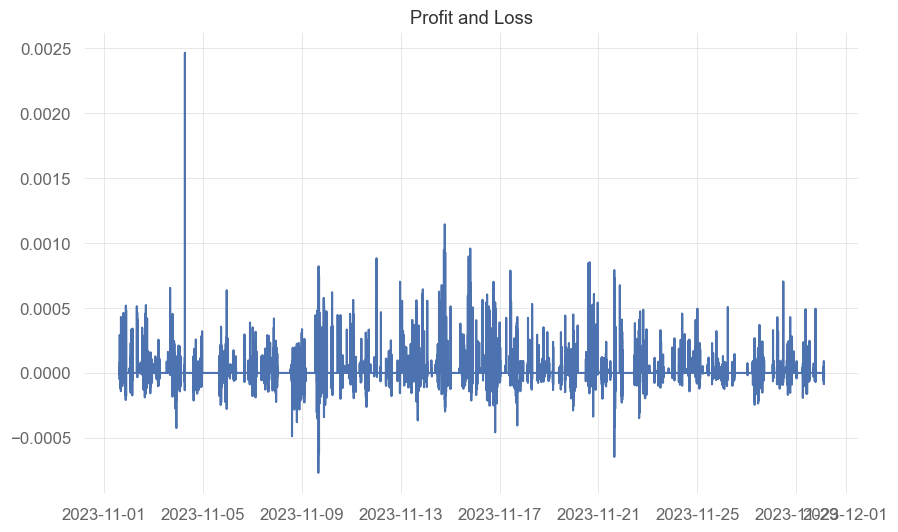

In [19]:
fig, ax = plt.subplots()

ax.set_title("Profit and Loss")
ax.plot(best_return['returns'])

plt.show()

                           Strategy
-------------------------  ----------
Start Period               2023-11-01
End Period                 2023-11-30
Risk-Free Rate             0.0%
Time in Market             23.0%

Cumulative Return          13.54%
CAGR﹪                     213.65%

Sharpe                     0.99
Prob. Sharpe Ratio         100.0%
Smart Sharpe               0.92
Sortino                    2.09
Smart Sortino              1.93
Sortino/√2                 1.48
Smart Sortino/√2           1.36
Omega                      1.62

Max Drawdown               -0.36%
Longest DD Days            2
Volatility (ann.)          0.08%
Calmar                     595.23
Skew                       7.98
Kurtosis                   224.35

Expected Daily %           0.0%
Expected Monthly %         13.54%
Expected Yearly %          13.54%
Kelly Criterion            19.99%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.01%
Expected Shortfall (cVaR)  -0.01%

Max Consecutive Wins    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-11-08,2023-11-08,2023-11-09,2,-0.358942,-0.324320
2,2023-11-21,2023-11-21,2023-11-21,1,-0.156008,-0.146961
3,2023-11-04,2023-11-04,2023-11-05,2,-0.153557,-0.140692
4,2023-11-03,2023-11-04,2023-11-04,1,-0.128189,-0.124889
5,2023-11-27,2023-11-27,2023-11-27,1,-0.126121,-0.121937


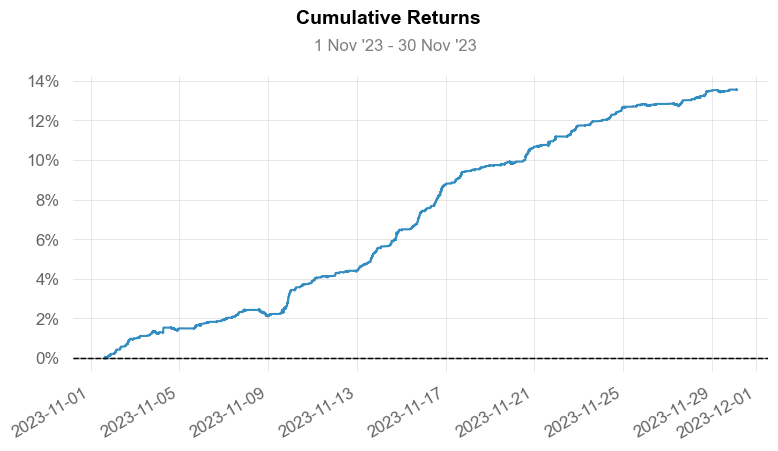

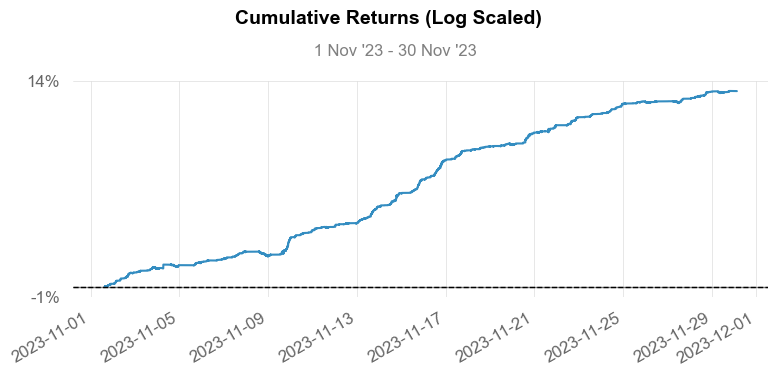

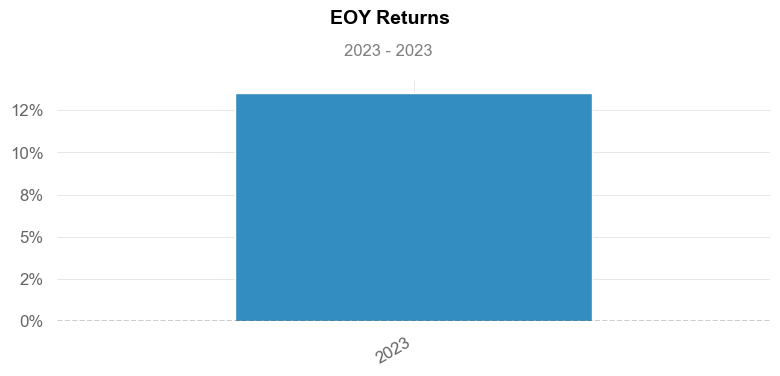

c:\Users\hyan212\Miniconda3\envs\btrl\lib\site-packages\quantstats\_plotting\core.py:516: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  _sns.kdeplot(data=combined_returns, color="black", ax=ax)


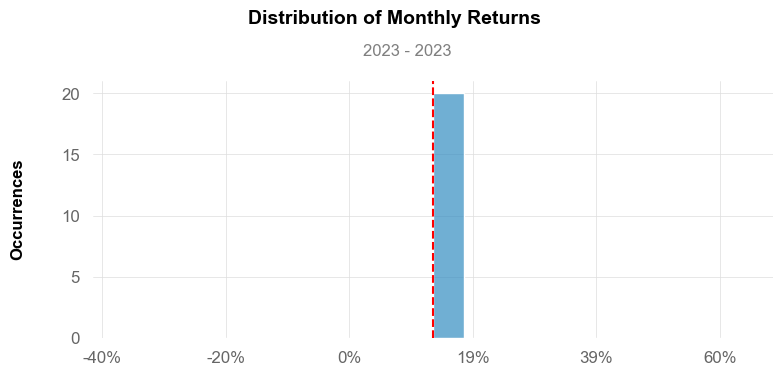

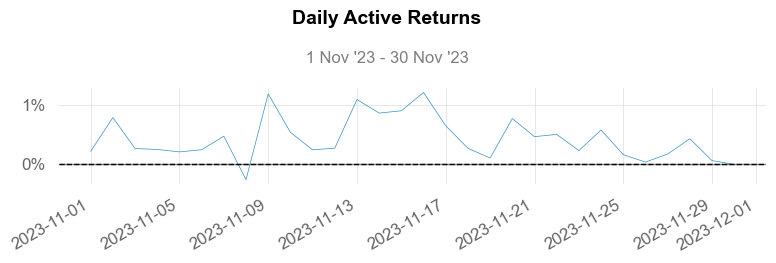

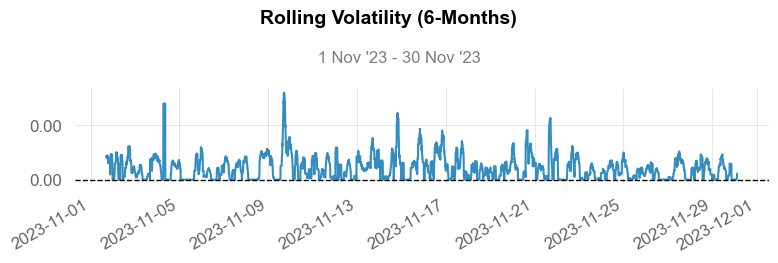

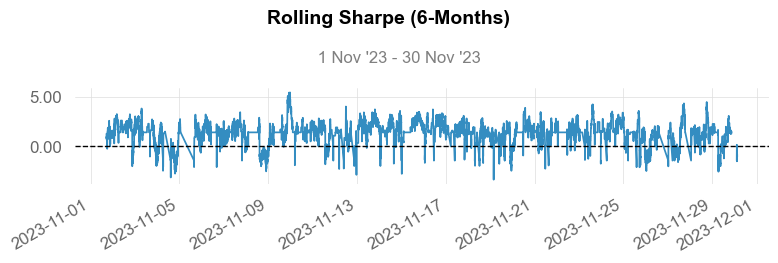

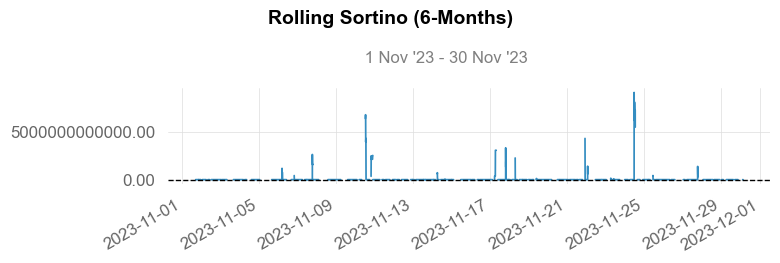

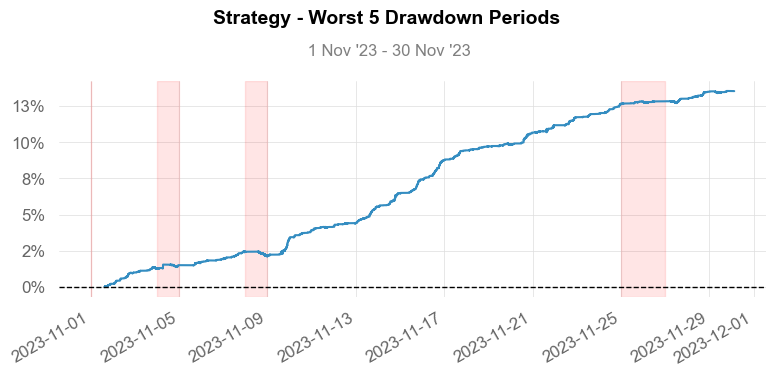

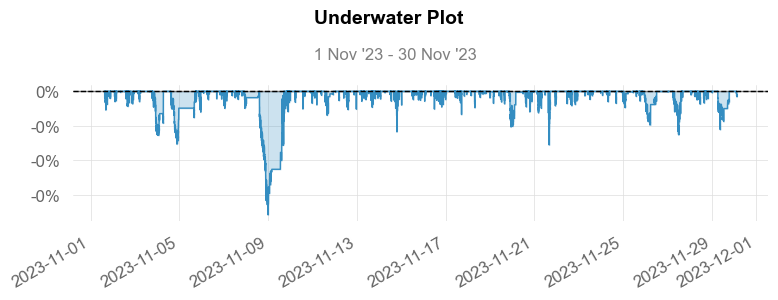

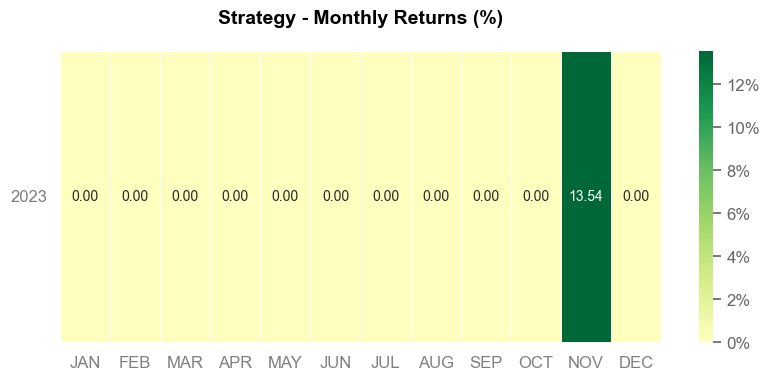

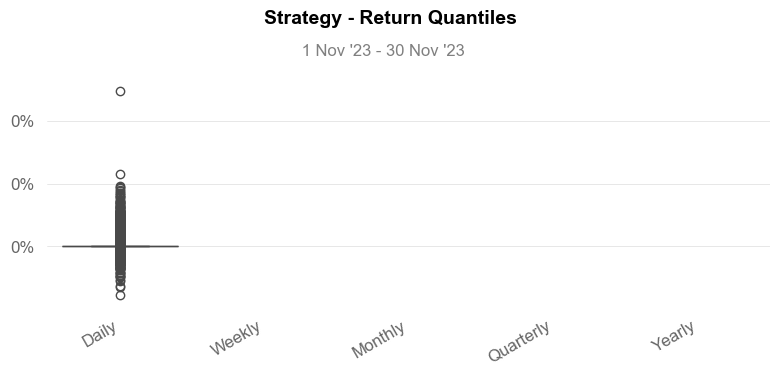

In [20]:
qs.reports.full(best_return['returns'])